cartesian slices of spherical dataset via custom fields and cut regions?

In [1]:
import yt
import numpy as np 
from yt.testing import fake_amr_ds

In [2]:
ds = fake_amr_ds(geometry='spherical')

yt : [INFO     ] 2023-11-27 11:48:57,558 Parameters: current_time              = 0.0
yt : [INFO     ] 2023-11-27 11:48:57,558 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2023-11-27 11:48:57,559 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-11-27 11:48:57,559 Parameters: domain_right_edge         = [1.         3.14159265 6.28318531]
yt : [INFO     ] 2023-11-27 11:48:57,559 Parameters: cosmological_simulation   = 0


define a plane in cartesian coordinates:

use 2 points on the surface and the sphere center to define 2 vectors.

Define points in spherical coordinates (r, theta, phi):

In [3]:
pt1 = (1.0, 20. * np.pi/180, 45. * np.pi/180)
pt2 = (1.0, 35. * np.pi/180, 75. * np.pi/180)
pt3 = (0., 0., 0.)

In [4]:
def to_cartesian(r, theta, phi):
    z = r * np.cos(theta)
    xy = r * np.sin(theta)
    x = xy * np.cos(phi)
    y = xy * np.sin(phi)
    return x, y, z


In [5]:
def _x(field, data):
    return data[('index', 'r')] * np.sin(data[('index', 'theta')]) * np.cos(data[('index', 'phi')])
    
def _y(field, data):
    return data[('index', 'r')] * np.sin(data[('index', 'theta')]) * np.sin(data[('index', 'phi')])

def _z(field, data):
    return data[('index', 'r')] * np.cos(data[('index', 'theta')])

ds.add_field(
    name=("index", "x"),
    function=_x,
    sampling_type="local",
    units="code_length",    
)

ds.add_field(
    name=("index", "y"),
    function=_y,
    sampling_type="local",
    units="code_length",    
)

ds.add_field(
    name=("index", "z"),
    function=_z,
    sampling_type="local",
    units="code_length",    
)

In [6]:
def _dist_from_plane(field, data):
    # always recalculate the cartesian plane in case
    # points have changed
    pt1_xyz = np.array(to_cartesian(*pt1))
    pt2_xyz = np.array(to_cartesian(*pt2))
    pt3_xyz = np.array(to_cartesian(*pt3))
    vec1 = pt1_xyz - pt3_xyz
    vec2 = pt2_xyz - pt3_xyz
    normal_vec = np.cross(vec1, vec2)
    vec_mag = np.sqrt(np.sum(normal_vec ** 2))
    normal_vec = normal_vec / vec_mag
    
    # get cartesian points of each data point
    x = data['index', 'x'].d
    y = data['index', 'y'].d
    z = data['index', 'z'].d
        
    # vector from each point to point on plane
    dist_vec = (x - pt1_xyz[0], y - pt1_xyz[1], z - pt1_xyz[2])
    
    # distance to plane for each point 
    dist = np.zeros(x.shape)
    for idim in range(3):
        dist += dist_vec[idim] * normal_vec[idim]
    dist = np.abs(dist) 
    return data.ds.arr(dist, 'code_length')

In [7]:
ds.add_field(
    name=("index", "dist_from_plane"),
    function=_dist_from_plane,
    sampling_type="local",
    units="code_length",
    force_override=True,
)

In [8]:
cr = ds.cut_region(ds.all_data(), ["obj[('index', 'dist_from_plane')] < 0.025"])

In [9]:
d = cr[('stream', 'Density')]
x = cr[('index', 'x')]
y = cr[('index', 'y')]
z = cr[('index', 'z')]
r = cr[('index', 'r')]

let's load this up in 3D to check ...

In [10]:
%matplotlib widget

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

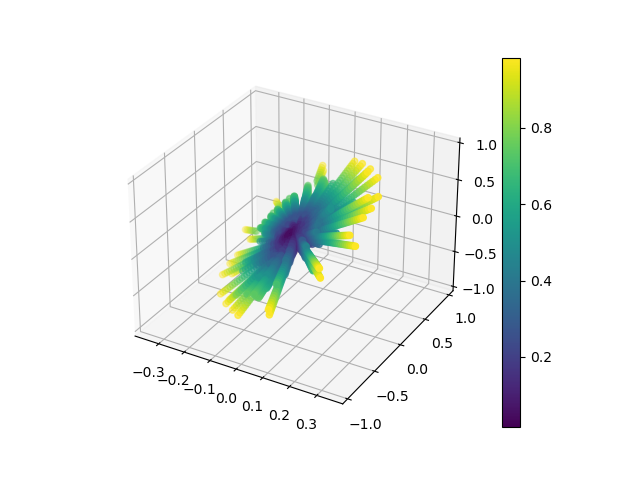

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(x, y, z, c=r)
plt.colorbar(sc, ax=ax)
plt.show()

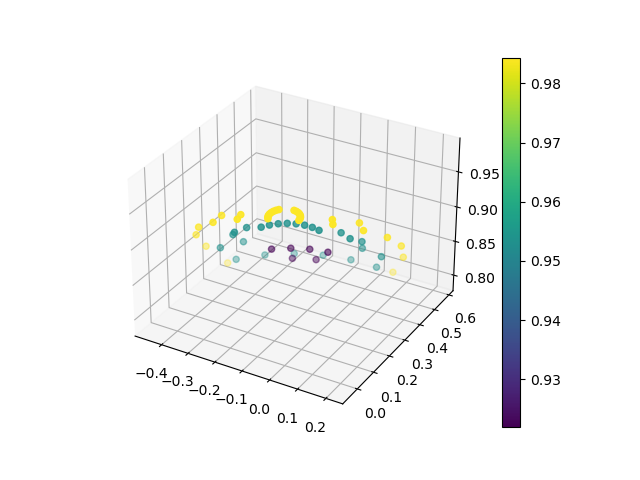

In [12]:
pt1 = (1.0, 20. * np.pi/180, 45. * np.pi/180)
pt2 = (1.0, 35. * np.pi/180, 75. * np.pi/180)
pt3 = (1.0, 35. * np.pi/180, 150. * np.pi/180)
cr = ds.cut_region(ds.all_data(), ["obj[('index', 'dist_from_plane')] < 0.01"])

x = cr[('index', 'x')]
y = cr[('index', 'y')]
z = cr[('index', 'z')]
r = cr[('index', 'r')]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(x, y, z, c=r)

plt.colorbar(sc, ax=ax)
plt.show()